<a href="https://colab.research.google.com/github/umKvFL6HsSQ7hfkS/dl-final-project/blob/main/100epoch_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 [==============================] - 3s 0us/step


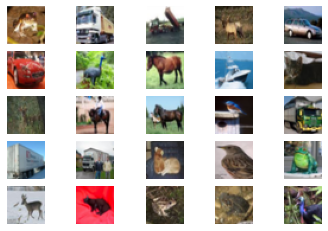

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1024)      52224       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 12ms/step
Epoch>94, Batch231/390, d1=0.686, d2=0.698 g=0.715
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch232/390, d1=0.677, d2=0.692 g=0.711
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch233/390, d1=0.701, d2=0.700 g=0.715
2/2 [==============================] - 0s 11ms/step
Epoch>94, Batch234/390, d1=0.682, d2=0.687 g=0.727
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch235/390, d1=0.694, d2=0.688 g=0.725
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch236/390, d1=0.687, d2=0.694 g=0.723
2/2 [==============================] - 0s 6ms/step
Epoch>94, Batch237/390, d1=0.679, d2=0.700 g=0.729
2/2 [==============================] - 0s 11ms/step
Epoch>94, Batch238/390, d1=0.695, d2=0.679 g=0.720
2/2 [==============================] - 0s 7ms/step
Epoch>94, Batch239/390, d1=0.685, d2=0.689 g=0.708
2/2 [=======================

Epoch>100, Batch390/390, d1=0.675, d2=0.695 g=0.710


In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt


(trainX, trainy), (testX, testy) = load_data()

for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()



def define_discriminator(in_shape=(32,32,3), n_classes=10):
	
  
	in_label = Input(shape=(1,)) 
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1] 
	li = Dense(n_nodes)(li) 
	
	li = Reshape((in_shape[0], in_shape[1], 1))(li) 
    
    
	in_image = Input(shape=in_shape) 
	
	merge = Concatenate()([in_image, li])
    
	
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) 
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)  
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe) 
    

	model = Model([in_image, in_label], out_layer)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


def define_generator(latent_dim, n_classes=10):
    
	in_label = Input(shape=(1,))

	li = Embedding(n_classes, 50)(in_label) 
    
	n_nodes = 8 * 8  
	li = Dense(n_nodes)(li) #1,64
	li = Reshape((8, 8, 1))(li) 

	in_lat = Input(shape=(latent_dim,)) 

	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat) 
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen)

	merge = Concatenate()([gen, li]) 

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) 
	gen = LeakyReLU(alpha=0.2)(gen)

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)

	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)

	model = Model([in_lat, in_label], out_layer)
	return model  

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())
 
def define_gan(g_model, d_model):
	d_model.trainable = False  
    
	gen_noise, gen_label = g_model.input 
	gen_output = g_model.output 
    
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


def load_real_samples():
	(trainX, trainy), (_, _) = load_data() 

	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5   
	return [X, trainy]


def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]

	#Label=1 indicating they are real
	y = ones((n_samples, 1))  
	return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]


def generate_fake_samples(generator, latent_dim, n_samples):

	z_input, labels_input = generate_latent_points(latent_dim, n_samples)

	images = generator.predict([z_input, labels_input])

#Label=0 indicating they are fake
	y = zeros((n_samples, 1))  
	return [images, labels_input], y

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2) 
                           
	for i in range(n_epochs):
		for j in range(bat_per_epo):

			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
	 
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
			y_gan = ones((n_batch, 1))

			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	g_model.save('cifar_conditional_generator_25epochs.h5')

#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

4/4 [==============================] - 0s 8ms/step


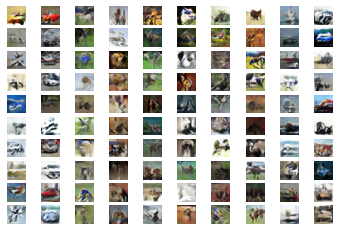

In [12]:
from numpy import asarray
import tensorflow as tf
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

model = load_model('cifar_conditional_generator_25epochs.h5')


latent_points, labels = generate_latent_points(100, 100)
labels = asarray([x for _ in range(10) for x in range(10)])
X  = model.predict([latent_points, labels])

X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

def show_plot(examples, n):
  # for i in range(n):
  #   plt.subplot(1, 1, 1)
  #   plt.axis('off')
  #   plt.imshow(examples[i])
  #   print(i//10)
    # # print(examples.labels)
    # filename = '/content/images/%d_generated_plot_e%03d.png' % (4,i+1)
    # plt.savefig(filename)

  labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  # for i in range(n):
  #   plt.figure()
  #   plt.subplot(1, 1, 1)
  #   plt.axis('off')
  #   plt.imshow(examples[i])
  #   # print(examples.labels)
  #   filename = '/content/one-images/%s/_generated_plot_e%03d.png' % (labels[i%10],i//10)
  #   tf.keras.preprocessing.image.save_img(filename, examples[i])
    # print(filename)
    # plt.savefig(filename)
  # plt.show()
  # with open ("file.txt", "W") as output:
  #   for i in range (0,1):
  #     with open ("file.txt", "W") as output:
  #       output.write(str(X[i, :, :]))

  for i in range(100):
    # plt.figure()
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  plt.show()
    
show_plot(X, 100)

In [7]:
!zip -r /content/file.zip /content/one-images
from google.colab import files
files.download("/content/file.zip")

  adding: content/one-images/ (stored 0%)
  adding: content/one-images/frog/ (stored 0%)
  adding: content/one-images/frog/_generated_plot_e005.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e003.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e000.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e002.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e008.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e006.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e004.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e009.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e001.png (stored 0%)
  adding: content/one-images/frog/_generated_plot_e007.png (stored 0%)
  adding: content/one-images/automobile/ (stored 0%)
  adding: content/one-images/automobile/_generated_plot_e005.png (stored 0%)
  adding: content/one-images/automobile/_generated_plot_e003.png (store

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>